# STOCK MARKET ANALYSIS FOR NEXT 30 DAYS

## EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('AAPL.csv', parse_dates=['Date'],dayfirst=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2011 non-null   datetime64[ns]
 1   Open       2011 non-null   float64       
 2   High       2011 non-null   float64       
 3   Low        2011 non-null   float64       
 4   Close      2011 non-null   float64       
 5   Adj Close  2011 non-null   float64       
 6   Volume     2011 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 110.1 KB


In [4]:
df=df.sort_values("Date")
df.set_index('Date', inplace=True)

In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,58.485714,58.928570,58.428570,58.747143,50.765709,75555200
2012-01-04,58.571430,59.240002,58.468571,59.062859,51.038536,65005500
2012-01-05,59.278572,59.792858,58.952858,59.718571,51.605175,67817400
2012-01-06,59.967144,60.392857,59.888573,60.342857,52.144630,79573200
2012-01-09,60.785713,61.107143,60.192856,60.247143,52.061932,98506100


In [6]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
# no missing values or duplicated values

In [10]:
df.describe(include="all")

,Open,High,Low,Close,Adj Close,Volume
count,2011.000000,2011.000000,2011.000000,2011.000000,2011.000000,2.011000e+03
mean,126.707469,127.827594,125.580258,126.741235,119.505548,5.949670e+07
std,50.483753,50.926301,50.124940,50.578369,52.438444,4.683856e+07
min,55.424286,57.085712,55.014286,55.790001,48.921928,1.136200e+07
25%,85.882858,86.717858,85.056427,86.202145,75.056679,2.758565e+07
50%,113.050003,114.190002,111.870003,113.050003,105.222908,4.346900e+07
75%,165.190002,167.409996,163.424995,165.245002,160.047111,7.471030e+07
max,291.119995,293.970001,288.119995,291.519989,289.522614,3.765300e+08


<Axes: >

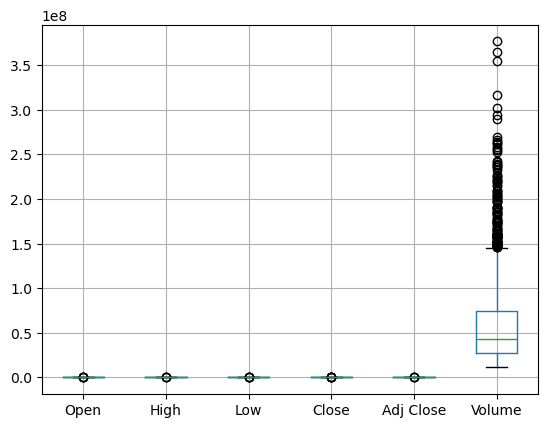

In [11]:
df.boxplot()

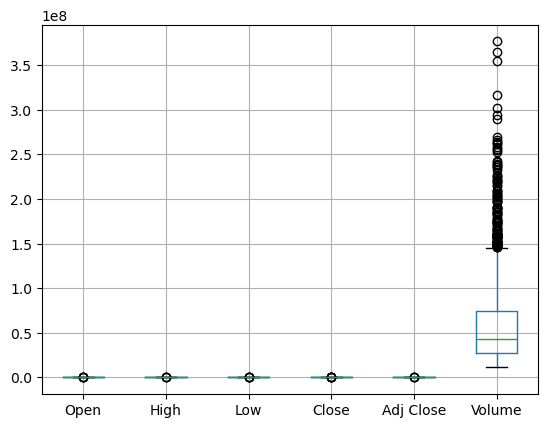

In [12]:
df.boxplot()
plt.show()

In [13]:
df.apply(skew)

Open         0.768777
High         0.770359
Low          0.770301
Close        0.773261
Adj Close    0.793464
Volume       2.163431
dtype: float64

In [14]:
df.apply(kurtosis)

Open        -0.174670
High        -0.177049
Low         -0.164201
Close       -0.157635
Adj Close   -0.167825
Volume       6.303529
dtype: float64

##### Correlation Matrix

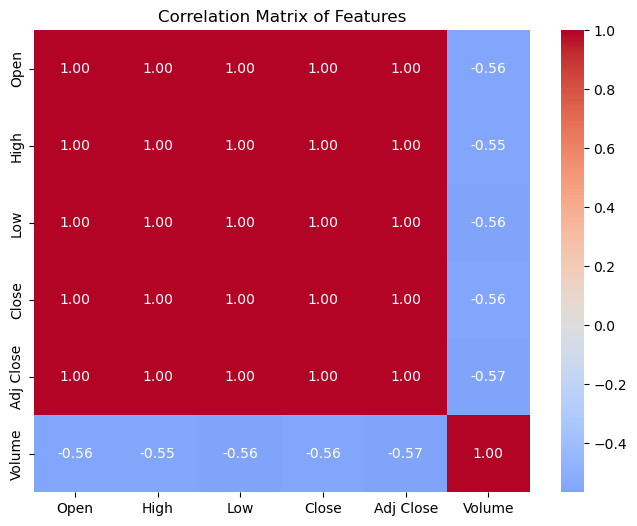

In [15]:
corr = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

In [16]:
num_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','Daily_Return']

##### Adj Closing Prices Over Time

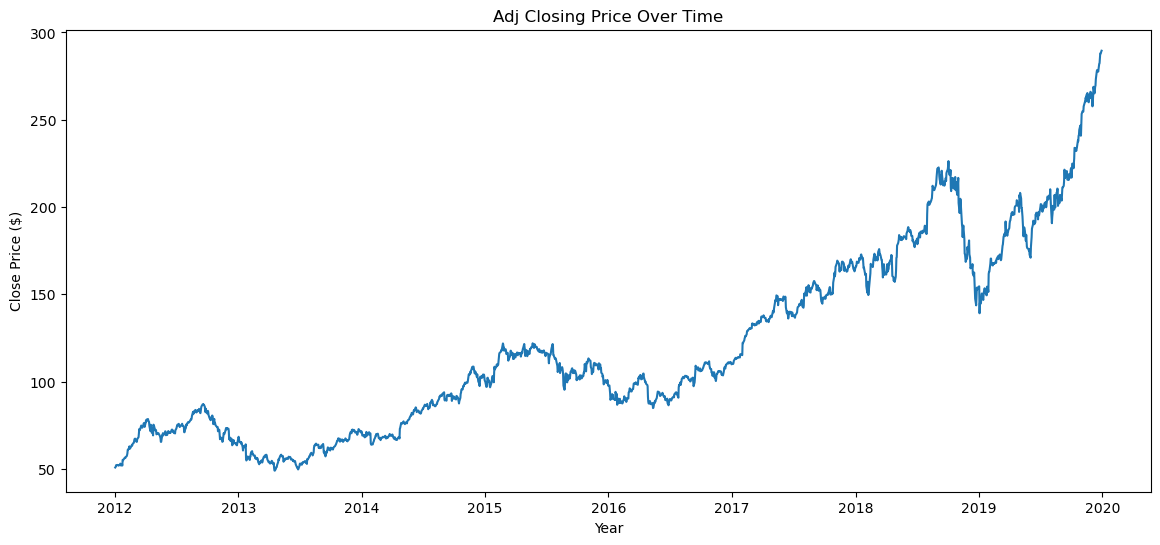

In [17]:
plt.figure(figsize=(14,6))
plt.plot( df['Adj Close'])
plt.title("Adj Closing Price Over Time")
plt.xlabel("Year")
plt.ylabel("Close Price ($)")
plt.show()


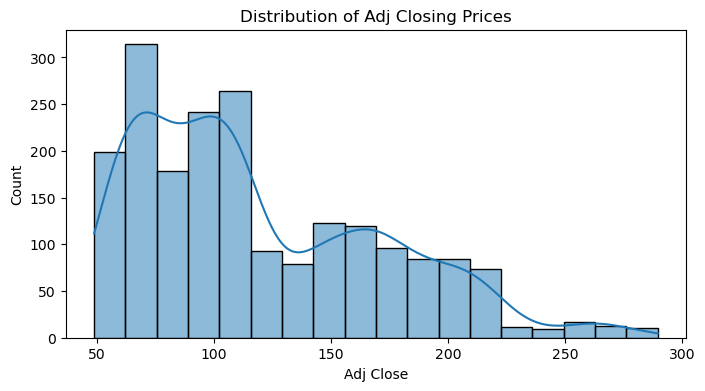

In [18]:
plt.figure(figsize=(8,4))
sns.histplot(df['Adj Close'], kde=True)
plt.title("Distribution of Adj Closing Prices")
plt.show()


 ##### Daily Price Change

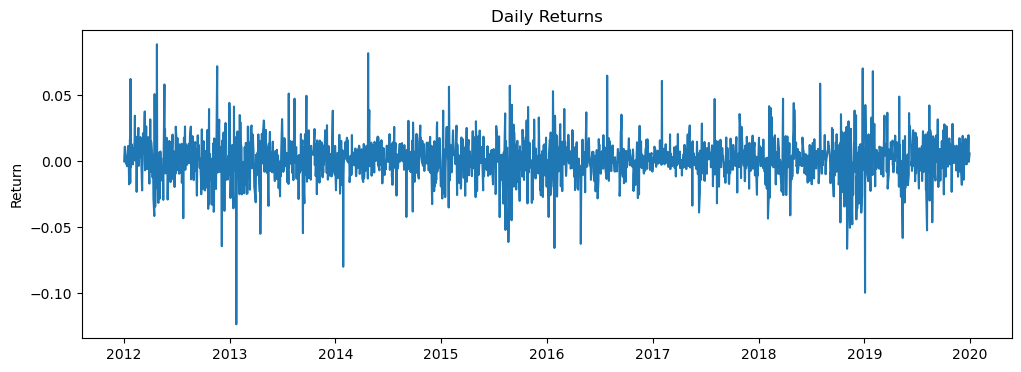

count    2011.000000
mean        0.000996
std         0.016103
min        -0.123558
25%        -0.006592
50%         0.000855
75%         0.009613
max         0.088741
Name: Daily_Return, dtype: float64


In [19]:
df['Daily_Return']=df['Adj Close'].pct_change()
df['Daily_Return']= df['Daily_Return'].fillna(0)
plt.figure(figsize=(12,4))
plt.plot( df['Daily_Return'])
plt.title("Daily Returns")
plt.ylabel("Return")
plt.show()
print(df['Daily_Return'].describe())


##### Volume Trend Analysis

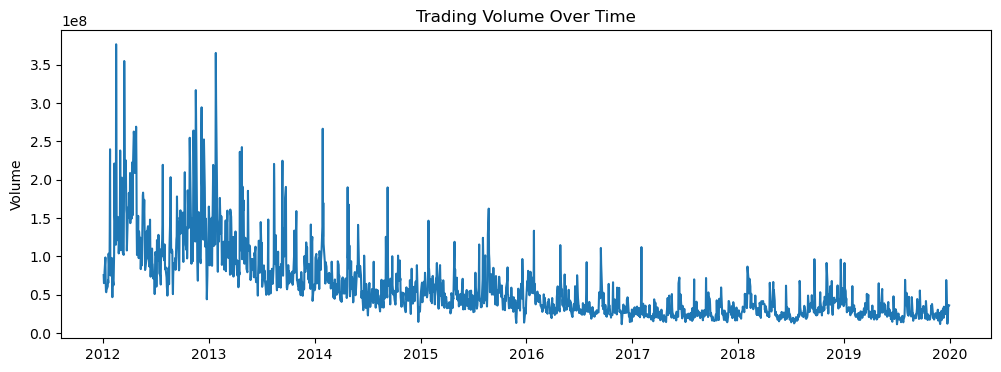

In [20]:
plt.figure(figsize=(12,4))
plt.plot( df['Volume'])
plt.title("Trading Volume Over Time")
plt.ylabel("Volume")
plt.show()


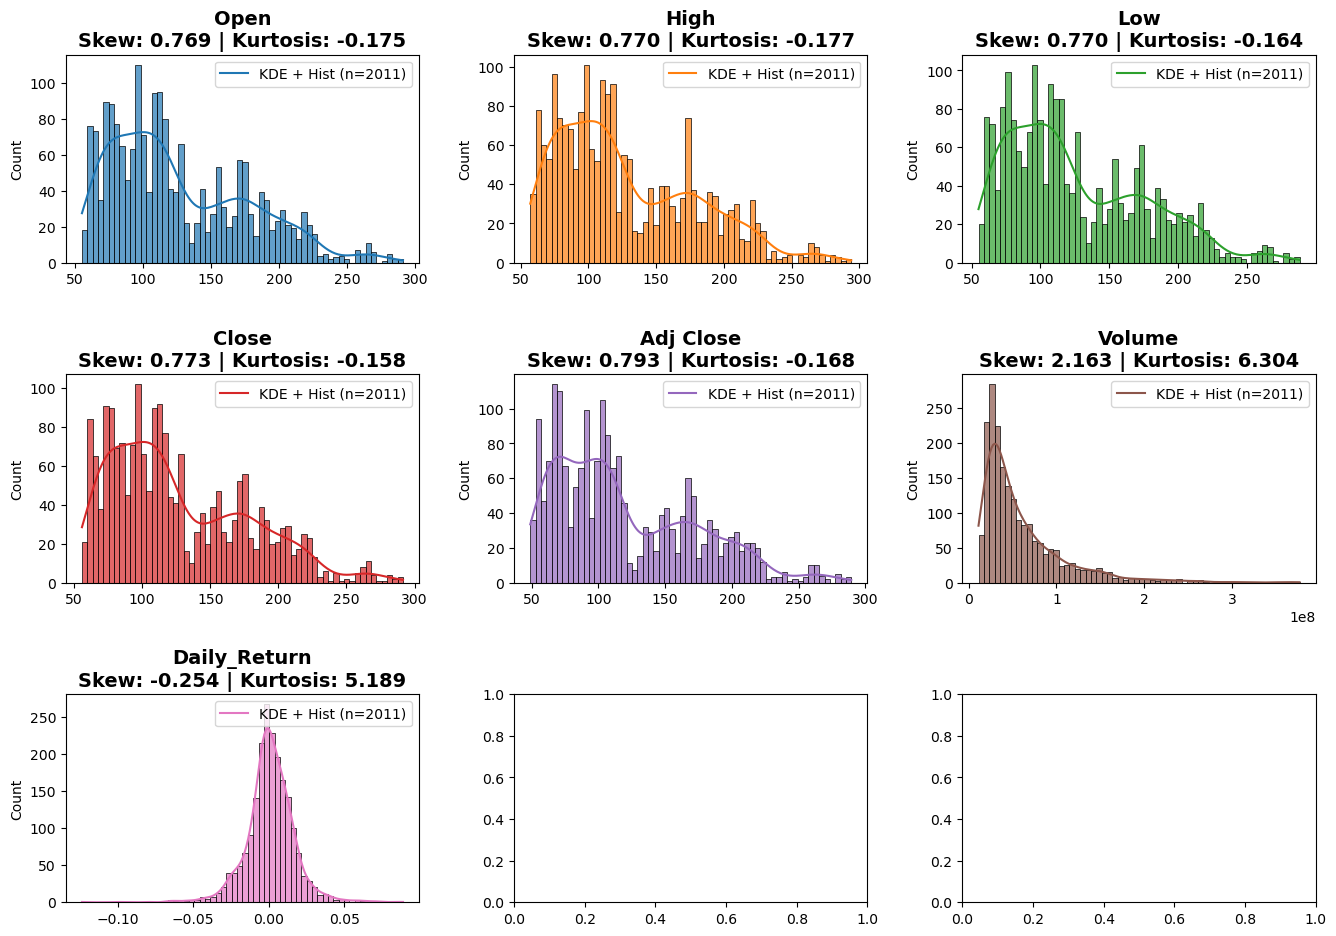

In [21]:
fig, axes = plt.subplots(3, 3, figsize=(14, 10))
axes = axes.ravel()

for i, col in enumerate(num_cols):
    data = df[col]
    s = skew(data)
    k = kurtosis(data)

    sns.histplot(
        data,
        bins=60,
        kde=True,
        ax=axes[i],
        color=sns.color_palette()[i],
        alpha=0.7,
        edgecolor='black',
        linewidth=0.5
    )
    axes[i].set_title(f'{col}\nSkew: {s:.3f} | Kurtosis: {k:.3f}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].legend([f'KDE + Hist (n={len(data)})'], loc='upper right')


plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=2.0)

plt.show()

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


vol = df['Volume'] #original volume
s_vol = skew(vol)
k_vol = kurtosis(vol)
sns.histplot(vol/1e6, bins=70, kde=True, ax=ax1, color='purple', alpha=0.7)
ax1.set_title(f'Volume\nSkew: {s_vol:.3f} | Kurtosis: {k_vol:.3f}', fontweight='bold')
ax1.set_xlabel('Volume')


df['Log_Volume'] = np.log1p(df['Volume']) #doing log transform
log_vol = df['Log_Volume']
s_log = skew(log_vol)
k_log = kurtosis(log_vol)
sns.histplot(log_vol, bins=60, kde=True, ax=ax2, color='teal', alpha=0.7)
ax2.set_title(f'Log Volume\nSkew: {s_log:.3f} | Kurtosis: {k_log:.3f} (Normal Distributed)', fontweight='bold')
ax2.set_xlabel('Log(Volume)')

Text(0.5, 0, 'Log(Volume)')

##### Seasonal decompose

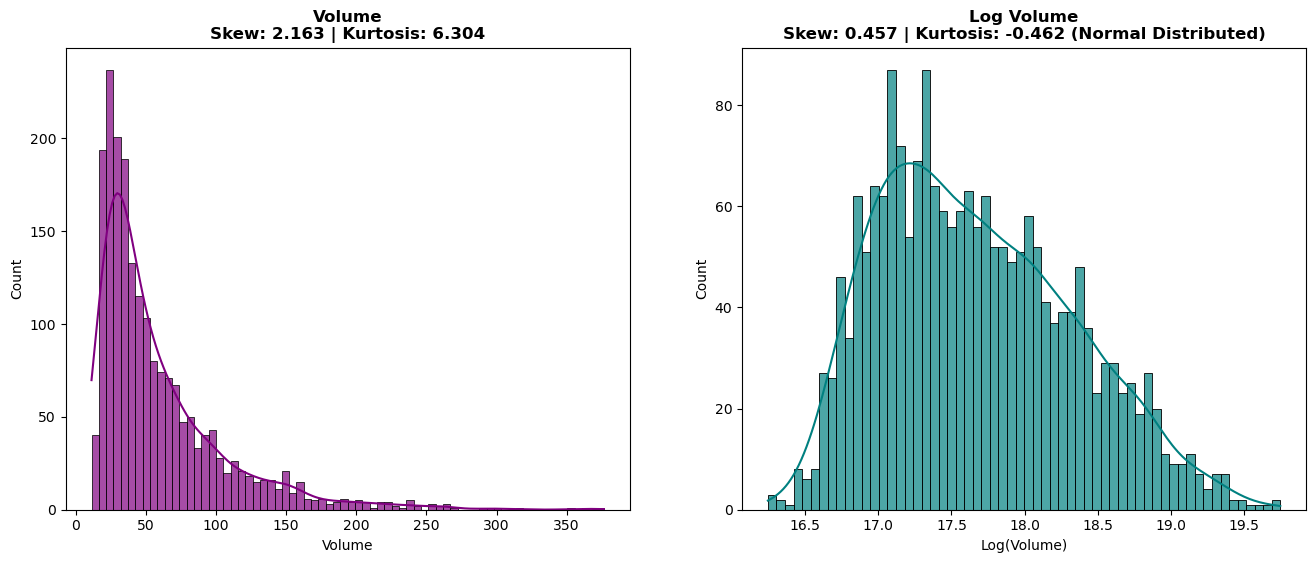

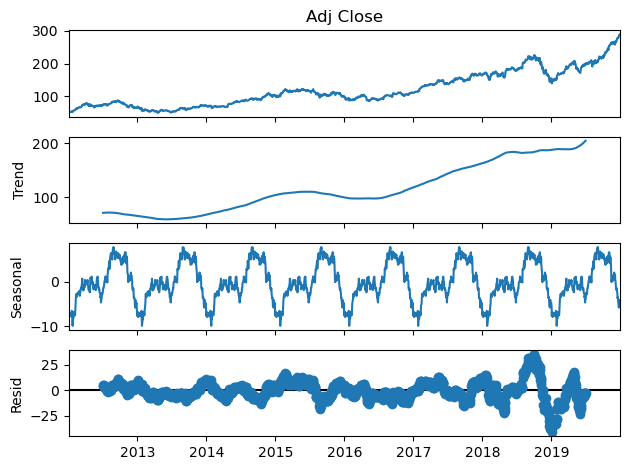

In [23]:
decomposition = seasonal_decompose(df['Adj Close'], model='additive', period=252)

decomposition.plot()
plt.show()

##### Rolling statistics

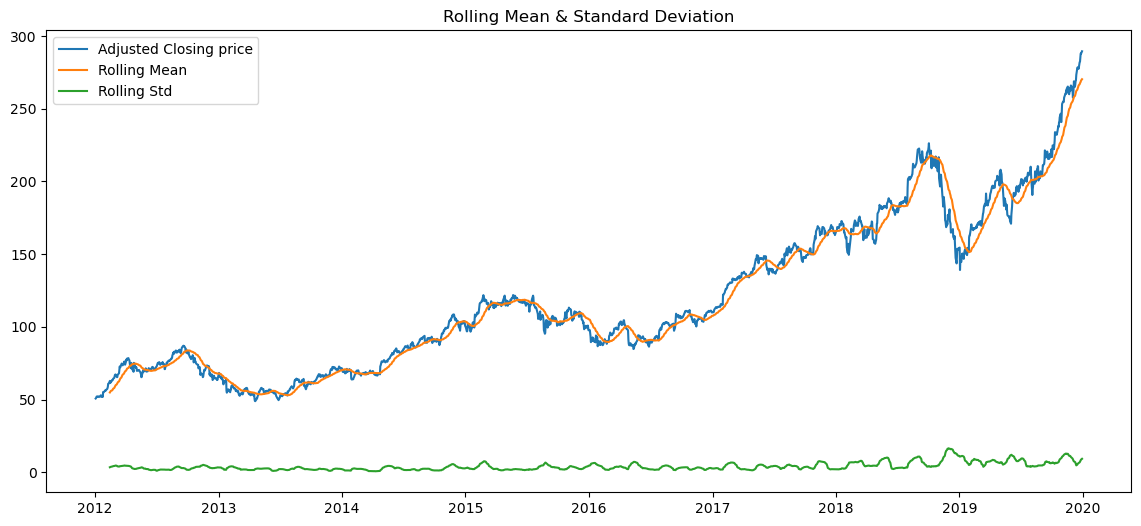

Overall Mean: 119.50554818299354
Overall Std: 52.43844358328904


In [24]:
rolling_mean = df['Adj Close'].rolling(window=30).mean()
rolling_std = df['Adj Close'].rolling(window=30).std()

plt.figure(figsize=(14,6))
plt.plot(df['Adj Close'], label='Adjusted Closing price')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.title("Rolling Mean & Standard Deviation")
plt.show()

print('Overall Mean:', df['Adj Close'].mean())
print('Overall Std:', df['Adj Close'].std())

##### AD fuller Test(Stationarity test)

In [25]:
adj_close_prices = df['Adj Close']

In [26]:
adf_result = adfuller(adj_close_prices)

In [27]:
adf_result[0]

1.4537998560856127

In [28]:
adf_result[4]

{'1%': -3.433622218212895,
 '5%': -2.8629854902259004,
 '10%': -2.5675395171404802}

In [29]:
adf_result[1]# not statinary

0.997345351966737

##### Differencing

Differenced ADF Statistics: -13.472640517995883
Differenced p-value: 3.359044895653832e-25


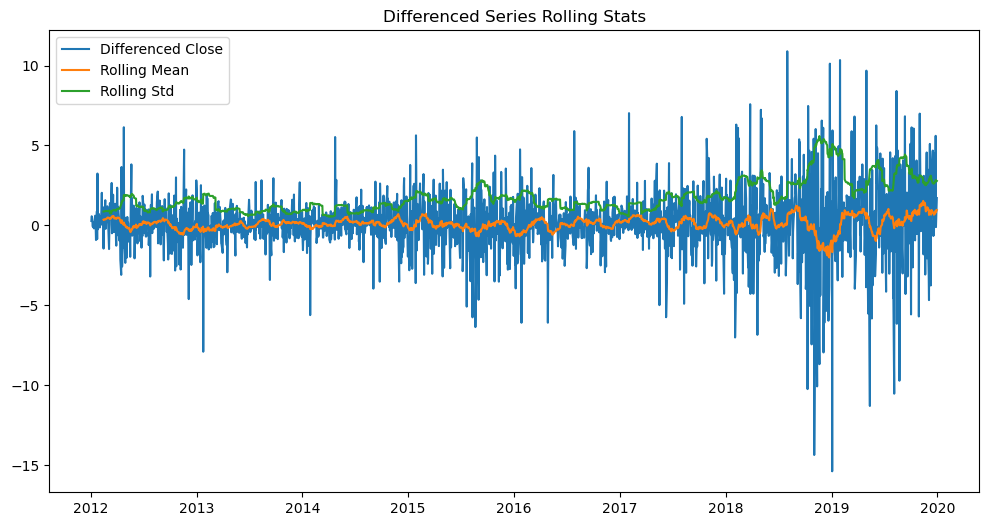

In [30]:
adj_close_diff = adj_close_prices.diff().dropna()
adf_diff = adfuller(adj_close_diff)
print('Differenced ADF Statistics:', adf_diff[0])
print('Differenced p-value:', adf_diff[1]) #d=1

rolling_mean_diff = adj_close_diff.rolling(30).mean()
rolling_std_diff = adj_close_diff.rolling(30).std()

plt.figure(figsize=(12,6))
plt.plot(adj_close_diff, label='Differenced Close')
plt.plot(rolling_mean_diff, label='Rolling Mean')
plt.plot(rolling_std_diff, label='Rolling Std')
plt.legend()
plt.title('Differenced Series Rolling Stats')
plt.show()

##### ACF & PACF

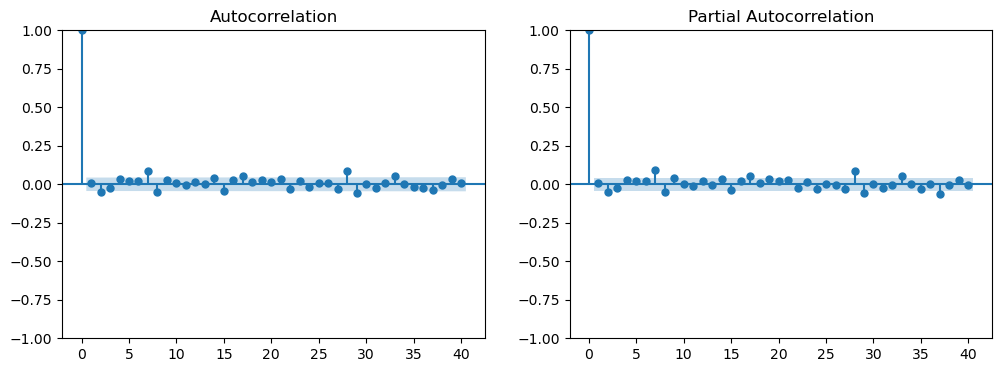

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
plot_acf(adj_close_diff, lags=40, ax=axs[0])
plot_pacf(adj_close_diff, lags=40, ax=axs[1])
plt.show()

## MODEL BUILDING AND EVALUATION

### 2)XGBOOSTER

In [32]:

df = df[['Adj Close']]
df.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

df.index = pd.to_datetime(df.index)

In [33]:
df['log_return'] = np.log(df['Adj_Close'] / df['Adj_Close'].shift(1))
df.dropna(inplace=True)

##### Feature Engineering

##### Create lag features

In [34]:
def create_features(df, lags=10):
    data = df.copy()

    for lag in range(1, lags + 1):
        data[f'ret_lag_{lag}'] = data['log_return'].shift(lag)

    data['rolling_mean_5'] = data['log_return'].rolling(5).mean()
    data['rolling_std_5']  = data['log_return'].rolling(5).std()

    return data

df_feat = create_features(df, lags=10)
df_feat.dropna(inplace=True)




##### Train–Test Split

In [35]:
train_size = int(len(df_feat) * 0.8)

train = df_feat.iloc[:train_size]
test  = df_feat.iloc[train_size:]

X_train = train.drop(['Adj_Close', 'log_return'], axis=1)
y_train = train['log_return']

X_test = test.drop(['Adj_Close', 'log_return'], axis=1)
y_test = test['log_return']




##### Building model

In [36]:
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)



,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [37]:
pred_returns = xgb_model.predict(X_test)

start_idx = df.index.get_loc(y_test.index[0])
last_price = df.iloc[start_idx - 1]['Adj_Close']


pred_prices = []
for r in pred_returns:
    last_price *= np.exp(r)
    pred_prices.append(last_price)

pred_prices = pd.Series(pred_prices, index=y_test.index)



##### Evaluation

In [38]:
print("RETURN METRICS")
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_returns)))
print("MAE :", mean_absolute_error(y_test, pred_returns))
actual_prices = df.loc[pred_prices.index, 'Adj_Close']

print("\nPRICE METRICS")
print("RMSE:", np.sqrt(mean_squared_error(actual_prices, pred_prices)))
print("MAE :", mean_absolute_error(actual_prices, pred_prices))




RETURN METRICS
RMSE: 0.010051626594489318
MAE : 0.006987338413355193

PRICE METRICS
RMSE: 7.388654725489254
MAE : 5.799038736137724


In [39]:
forecast_days = 30

future_dates = pd.bdate_range(
    start=df.index[-1],
    periods=forecast_days + 1
)[1:]





In [40]:
last_row = df_feat.iloc[-1:].copy()
future_prices = []

last_price = df['Adj_Close'].iloc[-1]

for _ in range(forecast_days):

    X_last = last_row.drop(['Adj_Close', 'log_return'], axis=1)
    next_return = xgb_model.predict(X_last)[0]

    last_price *= np.exp(next_return)
    future_prices.append(last_price)

    # shift return lags
    for lag in range(10, 1, -1):
        last_row[f'ret_lag_{lag}'] = last_row[f'ret_lag_{lag-1}']

    last_row['ret_lag_1'] = next_return

    recent = last_row[[f'ret_lag_{i}' for i in range(1, 6)]].values.flatten()
    last_row['rolling_mean_5'] = recent.mean()
    last_row['rolling_std_5']  = recent.std()

    last_row['log_return'] = next_return



In [41]:
forecast_df = pd.DataFrame(
    {'Forecast_Price': future_prices},
    index=future_dates
)

forecast_df.index = pd.to_datetime(forecast_df.index)



##### Forecasting

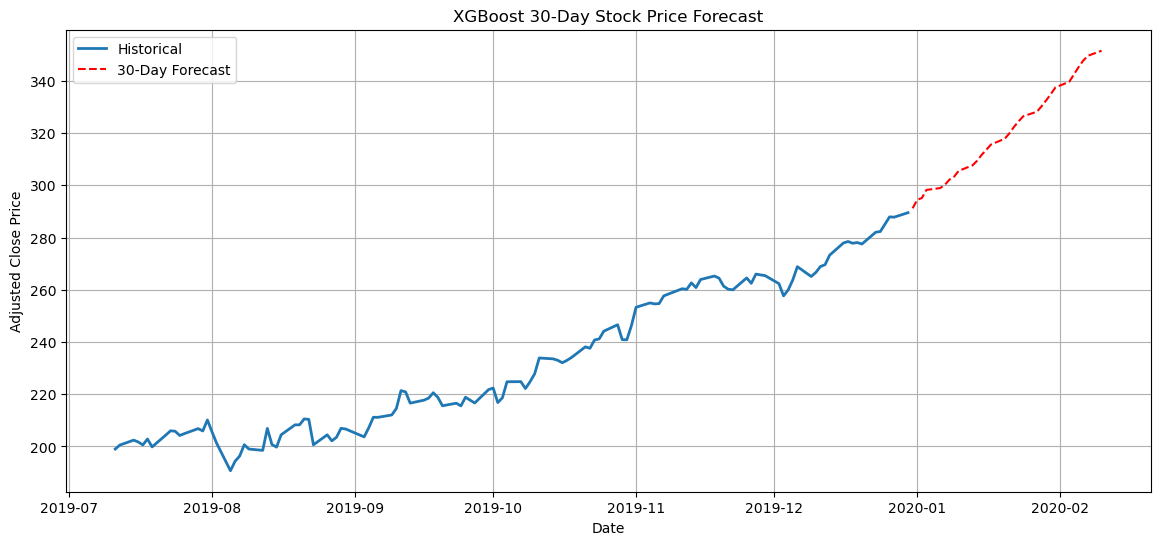

,Forecast_Price
2019-12-31,291.204816
2020-01-01,294.461991
2020-01-02,295.139787
2020-01-03,298.246306
2020-01-06,298.958483
2020-01-07,300.219413
2020-01-08,302.179860
2020-01-09,303.324804
2020-01-10,305.554195
2020-01-13,307.652888


In [42]:
plt.figure(figsize=(14,6))

plt.plot(
    df['Adj_Close'].iloc[-120:],
    label='Historical',
    linewidth=2
)

plt.plot(
    forecast_df.index,
    forecast_df['Forecast_Price'],
    label='30-Day Forecast',
    linestyle='--',color='red'
)

plt.title('XGBoost 30-Day Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

forecast_df


### HYPERPARAMETER TUNING|

In [43]:
tscv = TimeSeriesSplit(n_splits=5)


In [44]:
param_dist = {
    'n_estimators': [200, 300, 500, 800],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3]
}


In [45]:
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)


In [46]:
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=50,                 
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.03, ...], 'max_depth': [2, 3, ...], ...}"
,n_iter,50
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [47]:
print("Best Parameters Found:")
print(random_search.best_params_)


Best Parameters Found:
{'subsample': 0.8, 'n_estimators': 800, 'min_child_weight': 5, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


In [48]:
best_xgb = random_search.best_estimator_

best_xgb.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [49]:
tuned_pred_returns = best_xgb.predict(X_test)

print("TUNED MODEL – RETURN METRICS")
print("RMSE:", np.sqrt(mean_squared_error(y_test, tuned_pred_returns)))
print("MAE :", mean_absolute_error(y_test, tuned_pred_returns))



TUNED MODEL – RETURN METRICS
RMSE: 0.006596154787983665
MAE : 0.004225521816852251


In [50]:
start_idx = df.index.get_loc(y_test.index[0])
last_price = df.iloc[start_idx - 1]['Adj_Close']

tuned_prices = []
for r in tuned_pred_returns:
    last_price *= np.exp(r)
    tuned_prices.append(last_price)

tuned_prices = pd.Series(tuned_prices, index=y_test.index)


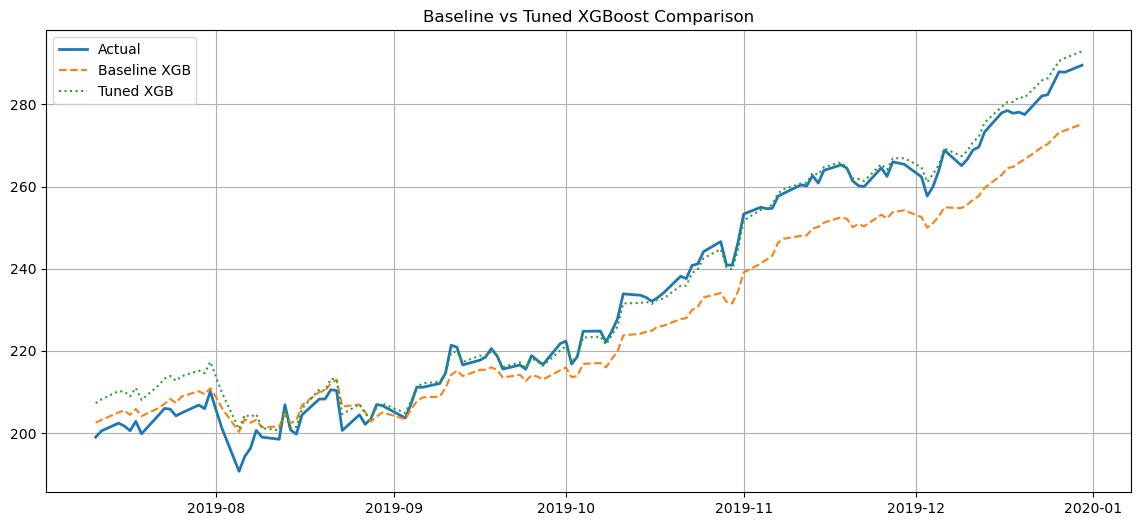

In [51]:
plt.figure(figsize=(14,6))

plt.plot(df['Adj_Close'].iloc[-120:], label='Actual', linewidth=2)
plt.plot(pred_prices.iloc[-120:], label='Baseline XGB', linestyle='--')
plt.plot(tuned_prices.iloc[-120:], label='Tuned XGB', linestyle=':')

plt.title('Baseline vs Tuned XGBoost Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [52]:
forecast_days = 30

future_dates = pd.bdate_range(
    start=df.index[-1],
    periods=forecast_days + 1
)[1:2019-12-31]   


In [53]:
last_row = df_feat.iloc[-1:].copy()
last_price = df['Adj_Close'].iloc[-1]

future_prices = []
future_returns = []


In [54]:
for _ in range(forecast_days):

    X_last = last_row.drop(['Adj_Close', 'log_return'], axis=1)

    next_return = best_xgb.predict(X_last)[0]

    # Convert return → price
    last_price *= np.exp(next_return)

    future_returns.append(next_return)
    future_prices.append(last_price)

    # Shift lag features
    for lag in range(10, 1, -1):
        last_row[f'ret_lag_{lag}'] = last_row[f'ret_lag_{lag-1}']

    last_row['ret_lag_1'] = next_return

    # Update rolling features
    recent_returns = last_row[[f'ret_lag_{i}' for i in range(1, 6)]].values.flatten()
    last_row['rolling_mean_5'] = recent_returns.mean()
    last_row['rolling_std_5']  = recent_returns.std()

    last_row['log_return'] = next_return


In [55]:
forecast_df = pd.DataFrame(
    {'Forecast_Price': future_prices},
    index=future_dates
)

forecast_df.head()


,Forecast_Price
2019-12-31,291.175272
2020-01-01,295.485728
2020-01-02,296.196949
2020-01-03,300.939994
2020-01-06,300.647901


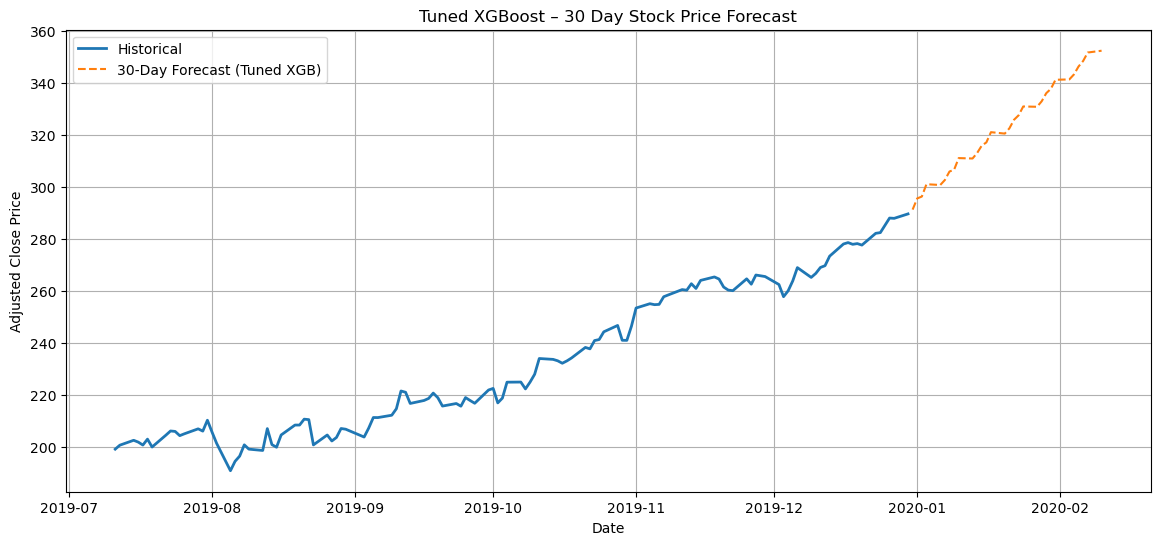

,Forecast_Price
2019-12-31,291.175272
2020-01-01,295.485728
2020-01-02,296.196949
2020-01-03,300.939994
2020-01-06,300.647901
2020-01-07,302.565450
2020-01-08,305.833050
2020-01-09,306.503442
2020-01-10,310.996563
2020-01-13,310.838036


In [56]:
plt.figure(figsize=(14,6))

plt.plot(
    df['Adj_Close'].iloc[-120:],
    label='Historical',
    linewidth=2
)

plt.plot(
    forecast_df.index,
    forecast_df['Forecast_Price'],
    label='30-Day Forecast (Tuned XGB)',
    linestyle='--'
)

plt.title('Tuned XGBoost – 30 Day Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

forecast_df

In [57]:
import pickle

with open("xgb_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)

print("Model saved using pickle")



Model saved using pickle
